In [ ]:
# Force reload modules each execution
%load_ext autoreload
%autoreload 2

# Load custom modules
from helper.ml_class import LinkPredict
from helper.custom_cv import CustomGroupCV, CustomGroupSplit
from helper.base import load_data

Training a model

In [2]:
# Load dataframe
meta, df = load_data(
    path_meta = 'data/processed/networks/subsamples_metadata.csv',
    path_subsample = 'data/processed/networks/subsamples_edge_lists.csv',
    paths_features = ['data/processed/features/features_py.csv'],
    filter_features = ['network_size','species_ratio', 'interactions_count', 'edge_connectivity', 'bipartite_clustering', 
                 'Spectral_bipartivity', 'average_clustering', 'degree_assortativity_coefficient', 'global_efficiency',
                 'local_efficiency', 'connected_components', 'degree_LL', 'latapy_clustering_LL', 'node_redundancy_LL', 
                 'betweenness_centrality_LL', 'degree_centrality_LL', 'closeness_centrality_LL', 'average_neighbor_degree_LL', 
                 'pagerank_LL', 'hits_hubs_LL', 'hits_authorities_LL', 'degree_HL', 
                 'latapy_clustering_HL', 'node_redundancy_HL', 'betweenness_centrality_HL', 'degree_centrality_HL', 
                 'closeness_centrality_HL', 'average_neighbor_degree_HL', 'pagerank_HL', 'hits_hubs_HL', 'hits_authorities_HL',
                 'preferential_attachment', 'friends_measure', 'shortest_path_length', 'shortest_paths_count']
)

df['class'] = df['class'].astype('int64')
df = df[[c for c in df if c not in ['class']] + ['class']]

# Columns to ignore during training
columns_ignore = ['name', 'link_ID', 'subsample_ID', 'fraction', 'repetition', 'higher_level', 'lower_level', 'weight']

Loading dataframe: 1it [00:00,  3.65it/s]
Loading features (features_py.csv): 23it [00:03,  5.79it/s]


In [3]:
cgs = CustomGroupSplit(
  group_by='name', 
  stratify_by='community', 
  fractions_col = 'fraction',
  train_size=0.8, 
  fractions_train = [1],
  fractions_test = [0.8], 
  groups_train = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
  groups_test = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
  drop_existing_links = True,
  keep_fractions_train=True, # Keep all fractions in train, although they are in fractions_train (will needed later)
  keep_fractions_test=False,
  random_state=42,
  )

train_idx, test_idx  = next(cgs.split(df))
train_link_id, test_link_id  = cgs.get_link_ids(0)

X_train, y_train = LinkPredict().subset_data(df, train_link_id, cast_target=False)
X_test, y_test = LinkPredict().subset_data(df, test_link_id, cast_target=True)

In [ ]:
cgc = CustomGroupCV(
    group_by='name', 
    stratify_by='community', 
    fractions_col = 'fraction',
    n_splits = 5,
    fractions_train = [1],
    fractions_test = [0.8],
    groups_train = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
    groups_test = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
    drop_existing_links = True
    )

ml = LinkPredict('RandomForestClassifier')

ml.params_dist['feature_selector']['k'] = [20, 25, 30, 35]

ml.fit(X_train,
       y_train,
       cv=cgc,
       class_weight='balanced',
       tuner_name='RandomizedSearchCV',
       columns_to_ignore=columns_ignore)

ml.multi_plot(X_test, y_test, threshold=0.5, 
    plots=['confusion_matrix', 'grouped_evaluation', 'roc_curve', 'pr_curve', 'probs_distribution', 'roc_curve_split', 'pr_curve_split', 'grouped_evaluation_split', 'feature_importance'])


In [7]:
# Export the model
ml.export_model('package/ecoILP/models/ecoILP')

# Creating a new model, for case study part of the paper

Remove the case study networks

In [8]:
df = df[~df['name'].str.startswith('A_HP_Pilosof2013')]

Training a model

In [9]:
cgs = CustomGroupSplit(
  group_by='name', 
  stratify_by='community', 
  fractions_col = 'fraction',
  train_size=0.8, 
  fractions_train = [1],
  fractions_test = [0.8], 
  groups_train = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
  groups_test = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
  drop_existing_links = True,
  keep_fractions_train=True, # Keep all fractions in train, although they are in fractions_train (will needed later)
  keep_fractions_test=False,
  random_state=42,
  )

train_idx, test_idx  = next(cgs.split(df))
train_link_id, test_link_id  = cgs.get_link_ids(0)

X_train, y_train = LinkPredict().subset_data(df, train_link_id, cast_target=False)
X_test, y_test = LinkPredict().subset_data(df, test_link_id, cast_target=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


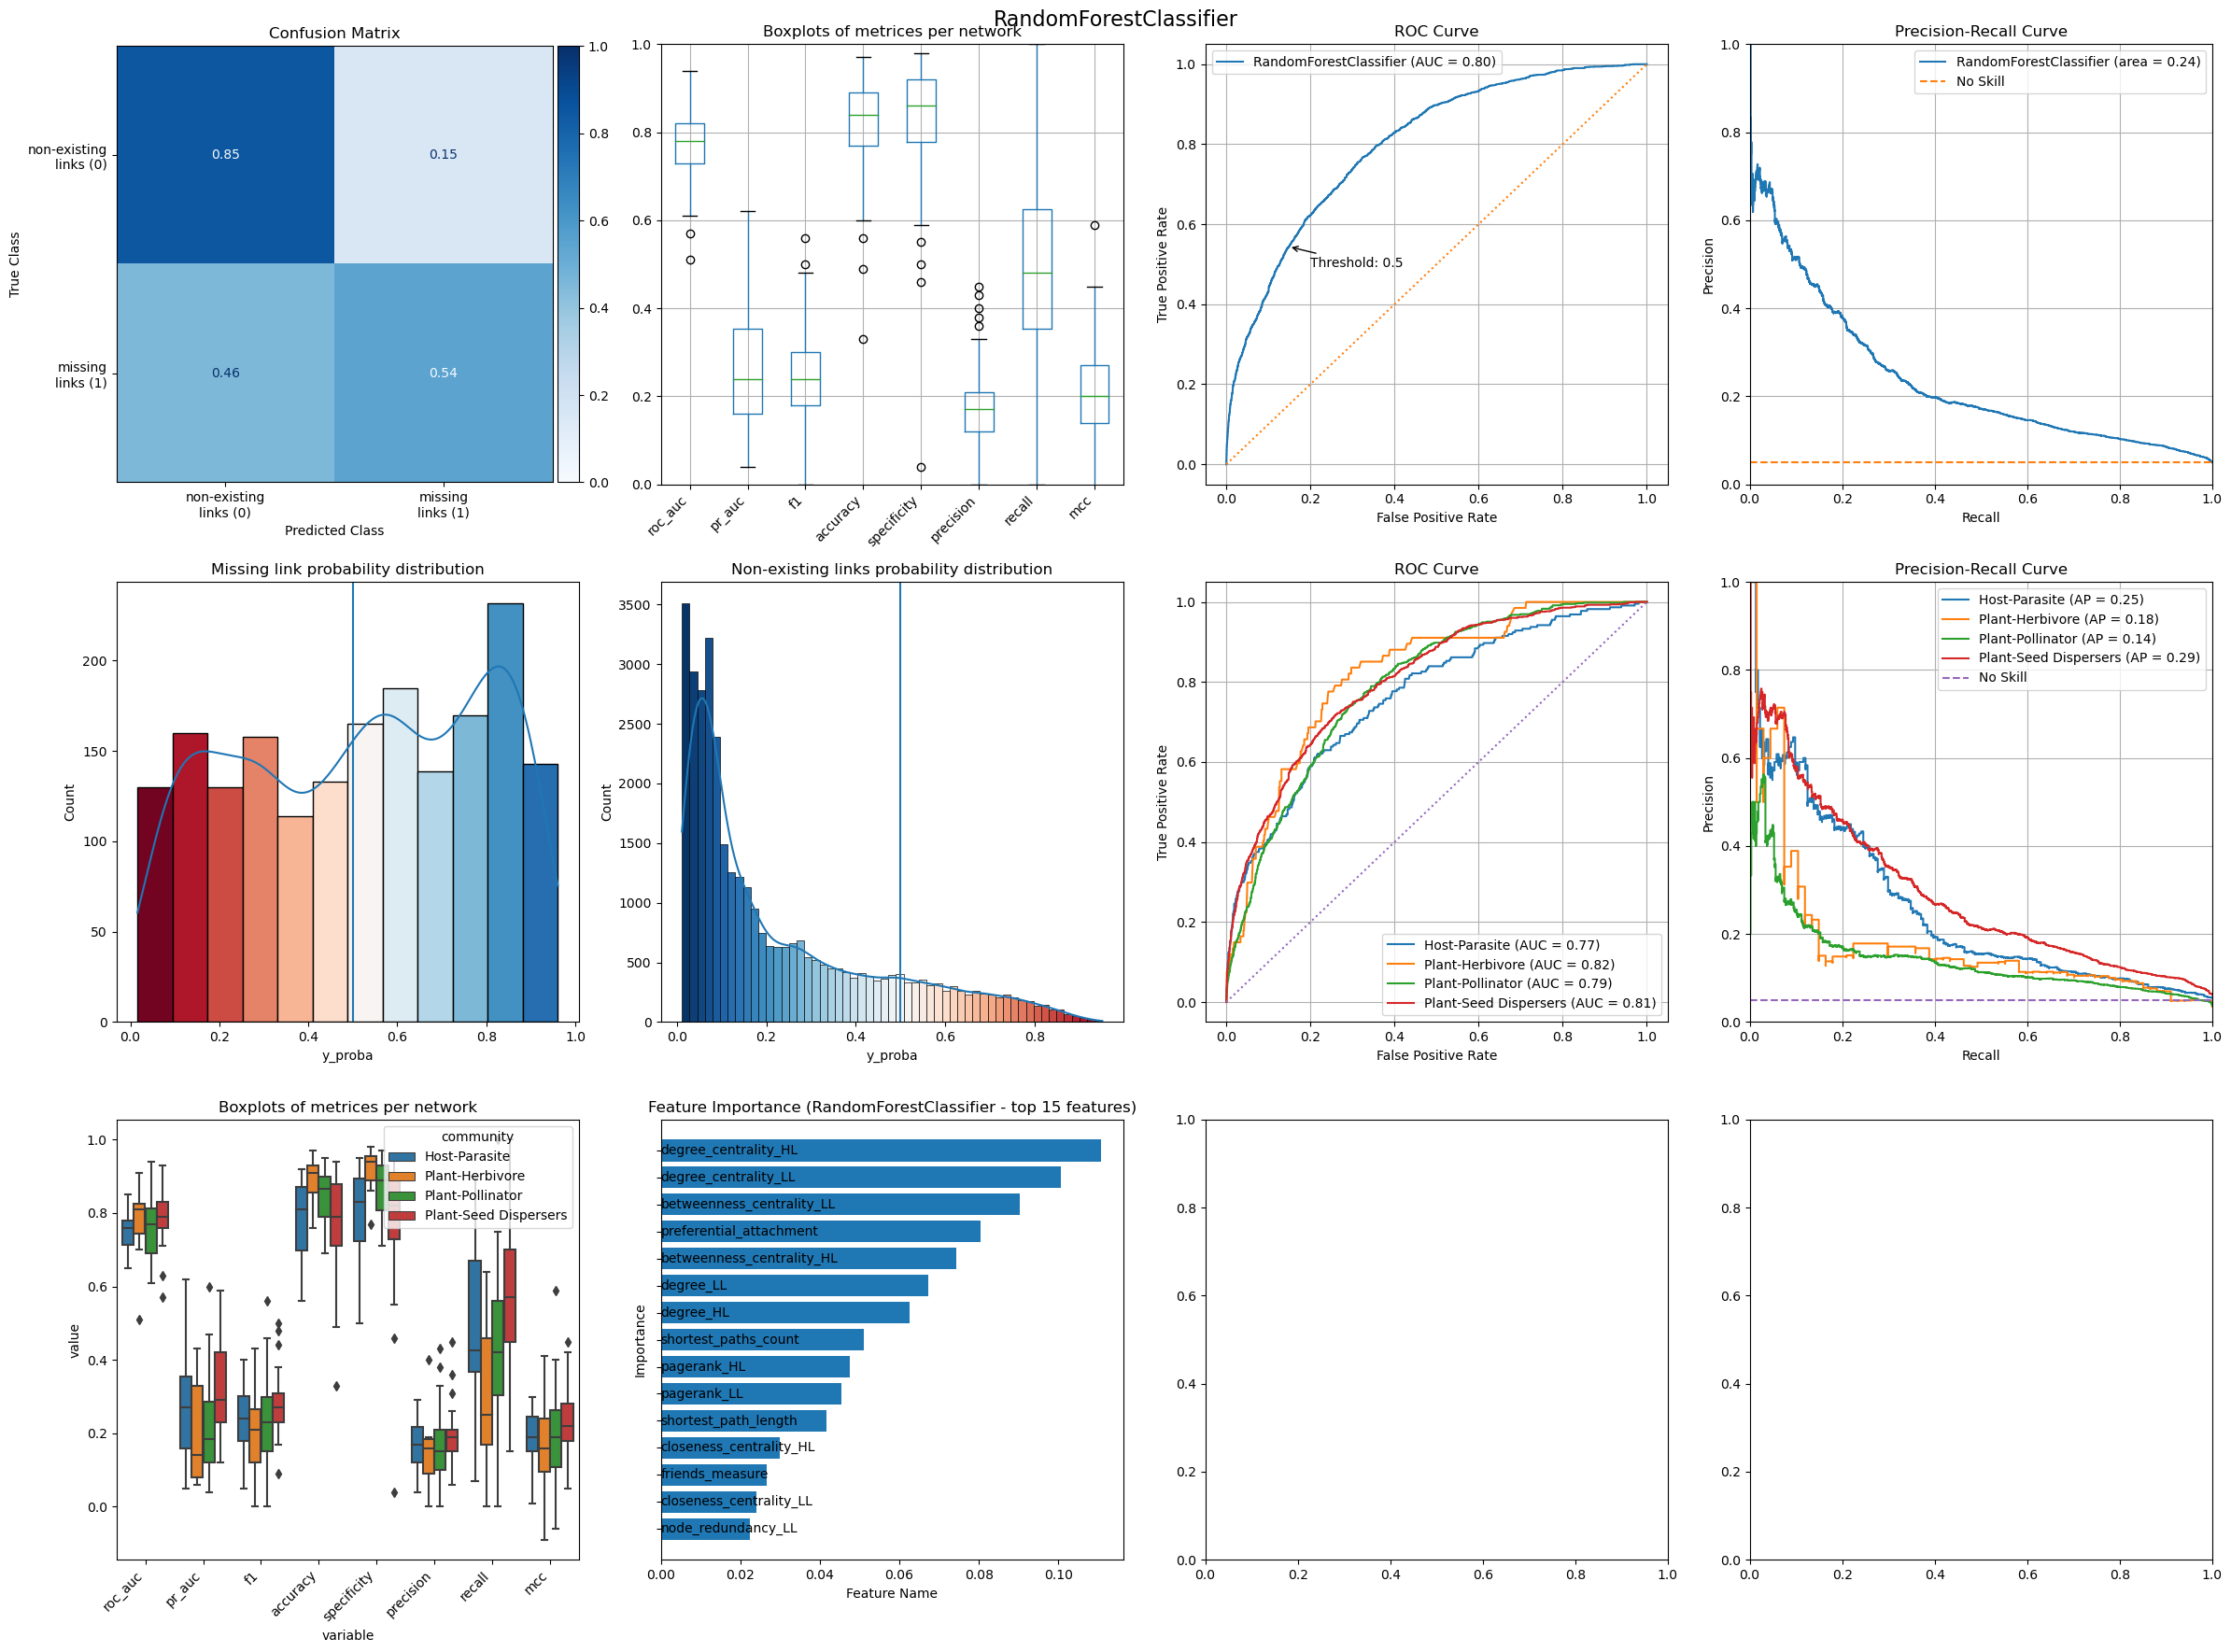

In [10]:
cgc = CustomGroupCV(
    group_by='name', 
    stratify_by='community', 
    fractions_col = 'fraction',
    n_splits = 5,
    fractions_train = [1],
    fractions_test = [0.8],
    groups_train = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
    groups_test = ['Plant-Seed Dispersers', 'Host-Parasite', 'Plant-Pollinator', 'Plant-Herbivore'],
    drop_existing_links = True
    )

ml = LinkPredict('RandomForestClassifier')

ml.params_dist['feature_selector']['k'] = [20, 25, 30, 35]

ml.fit(X_train,
       y_train,
       cv=cgc,
       class_weight='balanced',
       tuner_name='RandomizedSearchCV',
       columns_to_ignore=columns_ignore)

ml.multi_plot(X_test, y_test, threshold=0.5, 
    plots=['confusion_matrix', 'grouped_evaluation', 'roc_curve', 'pr_curve', 'probs_distribution', 'roc_curve_split', 'pr_curve_split', 'grouped_evaluation_split', 'feature_importance'])


In [11]:
# Export the model
ml.export_model('package/ecoILP/models/ecoILP_casestudy')